In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/iciar/train/'
test_dir = "data/iciar/test/"

extracted_features_dir = "extracted_features/"
model_name = "iciar_densenet"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/iciar/train/ 0
data/iciar/train/carcinoma 2310
data/iciar/train/non-carcinoma 2310
******************************
data/iciar/test/ 0
data/iciar/test/carcinoma 50
data/iciar/test/non-carcinoma 50


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3466 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3466
nb_validation_samples: 1154

predict_size_train: 109
predict_size_validation: 37
nb_test_samples: 100
predict_size_test: 4

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = DenseNet201(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

697 conv5_block31_concat
698 conv5_block32_0_bn
699 conv5_block32_0_relu
700 conv5_block32_1_conv
701 conv5_block32_1_bn
702 conv5_block32_1_relu
703 conv5_block32_2_conv
704 conv5_block32_concat
705 bn
706 relu
707 avg_pool


In [12]:
c1 = model.layers[9].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[55].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[143].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[483].output
c4 = GlobalAveragePooling2D()(c4)

con = concatenate([c1, c2, c3, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

                                                                 conv4_block11_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block12_0_bn (BatchNormal (None, 14, 14, 608)  2432        conv4_block11_concat[0][0]       
__________________________________________________________________________________________________
conv4_block12_0_relu (Activatio (None, 14, 14, 608)  0           conv4_block12_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block12_1_conv (Conv2D)   (None, 14, 14, 128)  77824       conv4_block12_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block12_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block12_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_bloc

conv4_block45_0_relu (Activatio (None, 14, 14, 1664) 0           conv4_block45_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block45_1_conv (Conv2D)   (None, 14, 14, 128)  212992      conv4_block45_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block45_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block45_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block45_1_relu (Activatio (None, 14, 14, 128)  0           conv4_block45_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block45_2_conv (Conv2D)   (None, 14, 14, 32)   36864       conv4_block45_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_bloc

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3466 samples, validate on 1154 samples
Epoch 1/1000
 - 3s - loss: 0.6876 - acc: 0.5542 - val_loss: 0.6787 - val_acc: 0.7019
Epoch 2/1000
 - 1s - loss: 0.6742 - acc: 0.6342 - val_loss: 0.6655 - val_acc: 0.7296
Epoch 3/1000
 - 1s - loss: 0.6593 - acc: 0.6826 - val_loss: 0.6514 - val_acc: 0.7028
Epoch 4/1000
 - 0s - loss: 0.6461 - acc: 0.7043 - val_loss: 0.6366 - val_acc: 0.7210
Epoch 5/1000
 - 1s - loss: 0.6319 - acc: 0.7147 - val_loss: 0.6217 - val_acc: 0.7435
Epoch 6/1000
 - 0s - loss: 0.6142 - acc: 0.7325 - val_loss: 0.6065 - val_acc: 0.7444
Epoch 7/1000
 - 1s - loss: 0.6004 - acc: 0.7271 - val_loss: 0.5932 - val_acc: 0.7478
Epoch 8/1000
 - 0s - loss: 0.5868 - acc: 0.7357 - val_loss: 0.5808 - val_acc: 0.7504
Epoch 9/1000
 - 0s - loss: 0.5757 - acc: 0.7343 - val_loss: 0.5682 - val_acc: 0.7444
Epoch 10/1000
 - 0s - loss: 0.5627 - acc: 0.7435 - val_loss: 0.5584 - val_acc: 0.7444
Epoch 11/1000
 - 0s - loss: 0.5531 - acc: 0.7441 - val_loss: 0.5492 - val_acc: 0.7444
Epoch 12/1000
 

Epoch 96/1000
 - 0s - loss: 0.4000 - acc: 0.8168 - val_loss: 0.3979 - val_acc: 0.8241
Epoch 97/1000
 - 0s - loss: 0.3983 - acc: 0.8211 - val_loss: 0.3971 - val_acc: 0.8206
Epoch 98/1000
 - 0s - loss: 0.3995 - acc: 0.8168 - val_loss: 0.4002 - val_acc: 0.8224
Epoch 99/1000
 - 0s - loss: 0.3968 - acc: 0.8234 - val_loss: 0.3981 - val_acc: 0.8180
Epoch 100/1000
 - 0s - loss: 0.3971 - acc: 0.8171 - val_loss: 0.3954 - val_acc: 0.8267
Epoch 101/1000
 - 0s - loss: 0.3960 - acc: 0.8278 - val_loss: 0.3945 - val_acc: 0.8215
Epoch 102/1000
 - 0s - loss: 0.3960 - acc: 0.8252 - val_loss: 0.3941 - val_acc: 0.8163
Epoch 103/1000
 - 0s - loss: 0.3951 - acc: 0.8243 - val_loss: 0.3959 - val_acc: 0.8206
Epoch 104/1000
 - 0s - loss: 0.3949 - acc: 0.8205 - val_loss: 0.3925 - val_acc: 0.8258
Epoch 105/1000
 - 0s - loss: 0.3925 - acc: 0.8292 - val_loss: 0.3919 - val_acc: 0.8189
Epoch 106/1000
 - 0s - loss: 0.3912 - acc: 0.8266 - val_loss: 0.3946 - val_acc: 0.8224
Epoch 107/1000
 - 0s - loss: 0.3920 - acc: 0.82

Epoch 191/1000
 - 0s - loss: 0.3313 - acc: 0.8609 - val_loss: 0.3311 - val_acc: 0.8622
Epoch 192/1000
 - 0s - loss: 0.3308 - acc: 0.8598 - val_loss: 0.3348 - val_acc: 0.8544
Epoch 193/1000
 - 0s - loss: 0.3308 - acc: 0.8592 - val_loss: 0.3310 - val_acc: 0.8579
Epoch 194/1000
 - 0s - loss: 0.3289 - acc: 0.8575 - val_loss: 0.3285 - val_acc: 0.8588
Epoch 195/1000
 - 0s - loss: 0.3283 - acc: 0.8641 - val_loss: 0.3278 - val_acc: 0.8605
Epoch 196/1000
 - 0s - loss: 0.3292 - acc: 0.8595 - val_loss: 0.3278 - val_acc: 0.8596
Epoch 197/1000
 - 0s - loss: 0.3271 - acc: 0.8627 - val_loss: 0.3270 - val_acc: 0.8631
Epoch 198/1000
 - 0s - loss: 0.3254 - acc: 0.8624 - val_loss: 0.3268 - val_acc: 0.8657
Epoch 199/1000
 - 1s - loss: 0.3274 - acc: 0.8578 - val_loss: 0.3260 - val_acc: 0.8640
Epoch 200/1000
 - 0s - loss: 0.3276 - acc: 0.8583 - val_loss: 0.3398 - val_acc: 0.8553
Epoch 201/1000
 - 0s - loss: 0.3260 - acc: 0.8624 - val_loss: 0.3276 - val_acc: 0.8657
Epoch 202/1000
 - 0s - loss: 0.3241 - acc: 

 - 0s - loss: 0.2592 - acc: 0.9005 - val_loss: 0.2621 - val_acc: 0.8977
Epoch 286/1000
 - 0s - loss: 0.2626 - acc: 0.8993 - val_loss: 0.2619 - val_acc: 0.8899
Epoch 287/1000
 - 0s - loss: 0.2578 - acc: 0.8967 - val_loss: 0.2753 - val_acc: 0.8951
Epoch 288/1000
 - 0s - loss: 0.2584 - acc: 0.9033 - val_loss: 0.2602 - val_acc: 0.9029
Epoch 289/1000
 - 0s - loss: 0.2587 - acc: 0.9005 - val_loss: 0.2593 - val_acc: 0.9038
Epoch 290/1000
 - 0s - loss: 0.2581 - acc: 0.9022 - val_loss: 0.2623 - val_acc: 0.8891
Epoch 291/1000
 - 0s - loss: 0.2592 - acc: 0.9028 - val_loss: 0.2578 - val_acc: 0.9038
Epoch 292/1000
 - 0s - loss: 0.2545 - acc: 0.9042 - val_loss: 0.2607 - val_acc: 0.9064
Epoch 293/1000
 - 0s - loss: 0.2546 - acc: 0.9031 - val_loss: 0.2563 - val_acc: 0.9003
Epoch 294/1000
 - 0s - loss: 0.2542 - acc: 0.9083 - val_loss: 0.2571 - val_acc: 0.9029
Epoch 295/1000
 - 0s - loss: 0.2547 - acc: 0.9106 - val_loss: 0.2554 - val_acc: 0.9038
Epoch 296/1000
 - 0s - loss: 0.2555 - acc: 0.9008 - val_lo

Epoch 380/1000
 - 0s - loss: 0.2032 - acc: 0.9284 - val_loss: 0.2118 - val_acc: 0.9246
Epoch 381/1000
 - 1s - loss: 0.2009 - acc: 0.9284 - val_loss: 0.2076 - val_acc: 0.9211
Epoch 382/1000
 - 0s - loss: 0.2047 - acc: 0.9296 - val_loss: 0.2050 - val_acc: 0.9289
Epoch 383/1000
 - 0s - loss: 0.2031 - acc: 0.9293 - val_loss: 0.2109 - val_acc: 0.9255
Epoch 384/1000
 - 0s - loss: 0.2034 - acc: 0.9247 - val_loss: 0.2068 - val_acc: 0.9237
Epoch 385/1000
 - 1s - loss: 0.2018 - acc: 0.9319 - val_loss: 0.2037 - val_acc: 0.9263
Epoch 386/1000
 - 1s - loss: 0.2030 - acc: 0.9256 - val_loss: 0.2111 - val_acc: 0.9237
Epoch 387/1000
 - 1s - loss: 0.1987 - acc: 0.9316 - val_loss: 0.2046 - val_acc: 0.9237
Epoch 388/1000
 - 0s - loss: 0.1987 - acc: 0.9293 - val_loss: 0.2098 - val_acc: 0.9229
Epoch 389/1000
 - 0s - loss: 0.1993 - acc: 0.9284 - val_loss: 0.2047 - val_acc: 0.9211
Epoch 390/1000
 - 0s - loss: 0.1968 - acc: 0.9322 - val_loss: 0.2020 - val_acc: 0.9255
Epoch 391/1000
 - 0s - loss: 0.2007 - acc: 

 - 1s - loss: 0.1606 - acc: 0.9452 - val_loss: 0.1725 - val_acc: 0.9411
Epoch 475/1000
 - 1s - loss: 0.1630 - acc: 0.9455 - val_loss: 0.1807 - val_acc: 0.9333
Epoch 476/1000
 - 0s - loss: 0.1626 - acc: 0.9446 - val_loss: 0.1919 - val_acc: 0.9263
Epoch 477/1000
 - 0s - loss: 0.1578 - acc: 0.9458 - val_loss: 0.1678 - val_acc: 0.9376
Epoch 478/1000
 - 0s - loss: 0.1602 - acc: 0.9449 - val_loss: 0.1651 - val_acc: 0.9402
Epoch 479/1000
 - 0s - loss: 0.1604 - acc: 0.9435 - val_loss: 0.1644 - val_acc: 0.9402
Epoch 480/1000
 - 0s - loss: 0.1580 - acc: 0.9443 - val_loss: 0.1774 - val_acc: 0.9359
Epoch 481/1000
 - 0s - loss: 0.1592 - acc: 0.9435 - val_loss: 0.1658 - val_acc: 0.9385
Epoch 482/1000
 - 0s - loss: 0.1578 - acc: 0.9460 - val_loss: 0.1642 - val_acc: 0.9393
Epoch 483/1000
 - 1s - loss: 0.1573 - acc: 0.9466 - val_loss: 0.1643 - val_acc: 0.9419
Epoch 484/1000
 - 1s - loss: 0.1572 - acc: 0.9469 - val_loss: 0.1739 - val_acc: 0.9359
Epoch 485/1000
 - 0s - loss: 0.1614 - acc: 0.9409 - val_lo

Epoch 569/1000
 - 0s - loss: 0.1306 - acc: 0.9582 - val_loss: 0.1363 - val_acc: 0.9471
Epoch 570/1000
 - 0s - loss: 0.1281 - acc: 0.9585 - val_loss: 0.1377 - val_acc: 0.9471
Epoch 571/1000
 - 0s - loss: 0.1279 - acc: 0.9582 - val_loss: 0.1387 - val_acc: 0.9454
Epoch 572/1000
 - 0s - loss: 0.1288 - acc: 0.9559 - val_loss: 0.1359 - val_acc: 0.9497
Epoch 573/1000
 - 0s - loss: 0.1281 - acc: 0.9570 - val_loss: 0.1356 - val_acc: 0.9480
Epoch 574/1000
 - 0s - loss: 0.1262 - acc: 0.9576 - val_loss: 0.1368 - val_acc: 0.9471
Epoch 575/1000
 - 0s - loss: 0.1286 - acc: 0.9570 - val_loss: 0.1323 - val_acc: 0.9471
Epoch 576/1000
 - 1s - loss: 0.1262 - acc: 0.9573 - val_loss: 0.1423 - val_acc: 0.9480
Epoch 577/1000
 - 0s - loss: 0.1313 - acc: 0.9561 - val_loss: 0.1401 - val_acc: 0.9445
Epoch 578/1000
 - 0s - loss: 0.1247 - acc: 0.9590 - val_loss: 0.1332 - val_acc: 0.9489
Epoch 579/1000
 - 0s - loss: 0.1250 - acc: 0.9593 - val_loss: 0.1326 - val_acc: 0.9489
Epoch 580/1000
 - 0s - loss: 0.1287 - acc: 

 - 0s - loss: 0.1049 - acc: 0.9674 - val_loss: 0.1127 - val_acc: 0.9567
Epoch 664/1000
 - 0s - loss: 0.1039 - acc: 0.9654 - val_loss: 0.1115 - val_acc: 0.9575
Epoch 665/1000
 - 0s - loss: 0.1054 - acc: 0.9645 - val_loss: 0.1099 - val_acc: 0.9567
Epoch 666/1000
 - 0s - loss: 0.1052 - acc: 0.9660 - val_loss: 0.1150 - val_acc: 0.9532
Epoch 667/1000
 - 0s - loss: 0.1063 - acc: 0.9645 - val_loss: 0.1128 - val_acc: 0.9558
Epoch 668/1000
 - 1s - loss: 0.1066 - acc: 0.9654 - val_loss: 0.1123 - val_acc: 0.9575
Epoch 669/1000
 - 1s - loss: 0.1022 - acc: 0.9660 - val_loss: 0.1171 - val_acc: 0.9558
Epoch 670/1000
 - 0s - loss: 0.1036 - acc: 0.9688 - val_loss: 0.1087 - val_acc: 0.9584
Epoch 671/1000
 - 0s - loss: 0.1036 - acc: 0.9665 - val_loss: 0.1117 - val_acc: 0.9549
Epoch 672/1000
 - 0s - loss: 0.1013 - acc: 0.9683 - val_loss: 0.1308 - val_acc: 0.9532
Epoch 673/1000
 - 0s - loss: 0.1090 - acc: 0.9631 - val_loss: 0.1121 - val_acc: 0.9567
Epoch 674/1000
 - 0s - loss: 0.1017 - acc: 0.9711 - val_lo

Epoch 758/1000
 - 1s - loss: 0.0852 - acc: 0.9743 - val_loss: 0.0904 - val_acc: 0.9688
Epoch 759/1000
 - 1s - loss: 0.0858 - acc: 0.9743 - val_loss: 0.0916 - val_acc: 0.9653
Epoch 760/1000
 - 0s - loss: 0.0848 - acc: 0.9758 - val_loss: 0.0915 - val_acc: 0.9671
Epoch 761/1000
 - 1s - loss: 0.0851 - acc: 0.9737 - val_loss: 0.0976 - val_acc: 0.9610
Epoch 762/1000
 - 1s - loss: 0.0861 - acc: 0.9711 - val_loss: 0.0917 - val_acc: 0.9688
Epoch 763/1000
 - 0s - loss: 0.0847 - acc: 0.9723 - val_loss: 0.0909 - val_acc: 0.9688
Epoch 764/1000
 - 0s - loss: 0.0828 - acc: 0.9740 - val_loss: 0.0987 - val_acc: 0.9619
Epoch 765/1000
 - 0s - loss: 0.0848 - acc: 0.9772 - val_loss: 0.0943 - val_acc: 0.9610
Epoch 766/1000
 - 0s - loss: 0.0856 - acc: 0.9749 - val_loss: 0.0927 - val_acc: 0.9723
Epoch 767/1000
 - 0s - loss: 0.0872 - acc: 0.9697 - val_loss: 0.1021 - val_acc: 0.9575
Epoch 768/1000
 - 0s - loss: 0.0847 - acc: 0.9761 - val_loss: 0.0990 - val_acc: 0.9619
Epoch 769/1000
 - 0s - loss: 0.0831 - acc: 

 - 1s - loss: 0.0693 - acc: 0.9821 - val_loss: 0.0778 - val_acc: 0.9705
Epoch 853/1000
 - 0s - loss: 0.0698 - acc: 0.9786 - val_loss: 0.0804 - val_acc: 0.9705
Epoch 854/1000
 - 0s - loss: 0.0699 - acc: 0.9795 - val_loss: 0.0829 - val_acc: 0.9714
Epoch 855/1000
 - 0s - loss: 0.0731 - acc: 0.9761 - val_loss: 0.0781 - val_acc: 0.9714
Epoch 856/1000
 - 0s - loss: 0.0761 - acc: 0.9766 - val_loss: 0.0802 - val_acc: 0.9740
Epoch 857/1000
 - 0s - loss: 0.0724 - acc: 0.9804 - val_loss: 0.0790 - val_acc: 0.9723
Epoch 858/1000
 - 0s - loss: 0.0669 - acc: 0.9792 - val_loss: 0.0779 - val_acc: 0.9688
Epoch 859/1000
 - 0s - loss: 0.0710 - acc: 0.9761 - val_loss: 0.0758 - val_acc: 0.9757
Epoch 860/1000
 - 0s - loss: 0.0718 - acc: 0.9804 - val_loss: 0.0893 - val_acc: 0.9653
Epoch 861/1000
 - 0s - loss: 0.0720 - acc: 0.9758 - val_loss: 0.0844 - val_acc: 0.9705
Epoch 862/1000
 - 0s - loss: 0.0746 - acc: 0.9755 - val_loss: 0.0748 - val_acc: 0.9766
Epoch 863/1000
 - 0s - loss: 0.0738 - acc: 0.9784 - val_lo

Epoch 947/1000
 - 0s - loss: 0.0603 - acc: 0.9838 - val_loss: 0.0664 - val_acc: 0.9757
Epoch 948/1000
 - 0s - loss: 0.0618 - acc: 0.9824 - val_loss: 0.0693 - val_acc: 0.9757
Epoch 949/1000
 - 0s - loss: 0.0599 - acc: 0.9812 - val_loss: 0.0724 - val_acc: 0.9714
Epoch 950/1000
 - 0s - loss: 0.0608 - acc: 0.9827 - val_loss: 0.0644 - val_acc: 0.9792
Epoch 951/1000
 - 0s - loss: 0.0612 - acc: 0.9818 - val_loss: 0.0660 - val_acc: 0.9766
Epoch 952/1000
 - 0s - loss: 0.0613 - acc: 0.9830 - val_loss: 0.0658 - val_acc: 0.9801
Epoch 953/1000
 - 0s - loss: 0.0586 - acc: 0.9818 - val_loss: 0.0754 - val_acc: 0.9705
Epoch 954/1000
 - 0s - loss: 0.0622 - acc: 0.9824 - val_loss: 0.0659 - val_acc: 0.9809
Epoch 955/1000
 - 0s - loss: 0.0614 - acc: 0.9838 - val_loss: 0.0635 - val_acc: 0.9783
Epoch 956/1000
 - 0s - loss: 0.0567 - acc: 0.9830 - val_loss: 0.0638 - val_acc: 0.9792
Epoch 957/1000
 - 0s - loss: 0.0590 - acc: 0.9841 - val_loss: 0.0663 - val_acc: 0.9757
Epoch 958/1000
 - 1s - loss: 0.0559 - acc: 

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.85


Confusion Matrix
[[43  7]
 [ 8 42]]


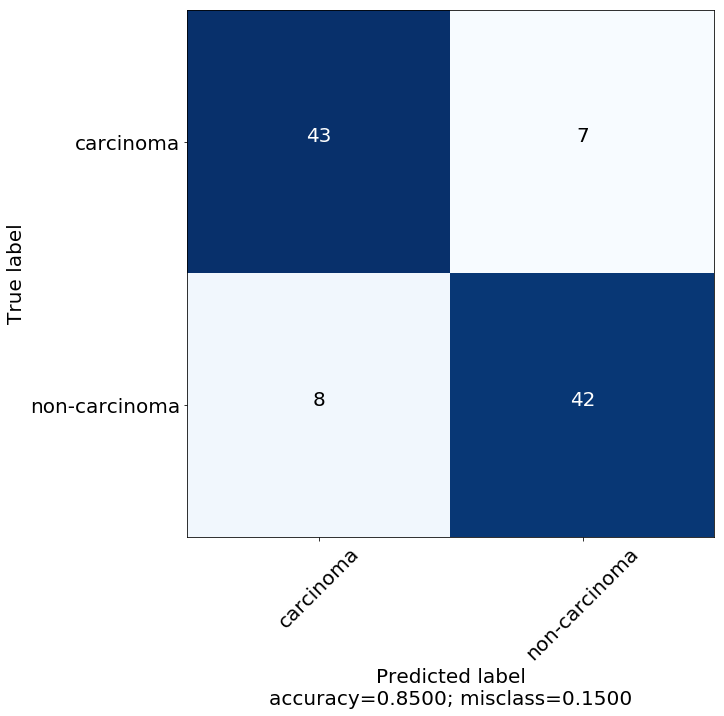

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[43  7]
 [ 8 42]]
               precision    recall  f1-score   support

non-carcinoma       0.84      0.86      0.85        50
    carcinoma       0.86      0.84      0.85        50

    micro avg       0.85      0.85      0.85       100
    macro avg       0.85      0.85      0.85       100
 weighted avg       0.85      0.85      0.85       100



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  84.31372549019608
Specificity :  85.71428571428571


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8501400560224089


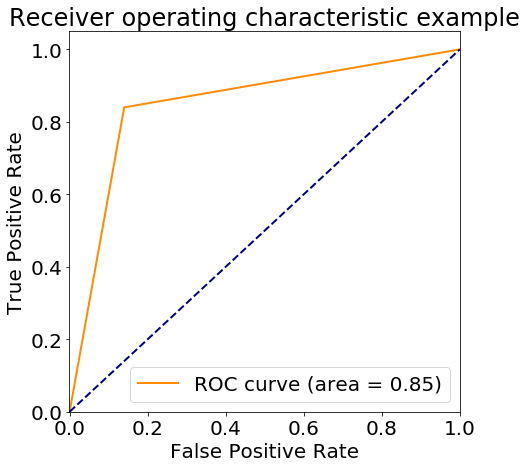

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

100/100 [==============================] - 0s 110us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

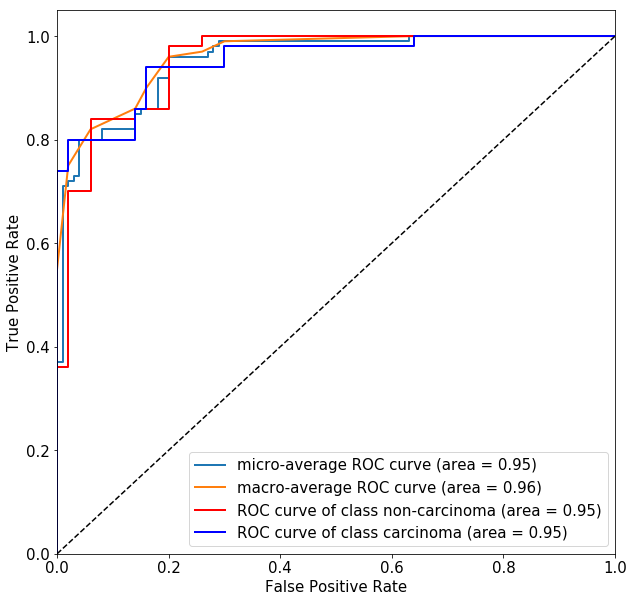

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.85
Precision: 0.8571428571428571
Recall: 0.84
tp: 42
fp: 7
tn: 43
fn: 8


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8484848484848485


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8484848484848485


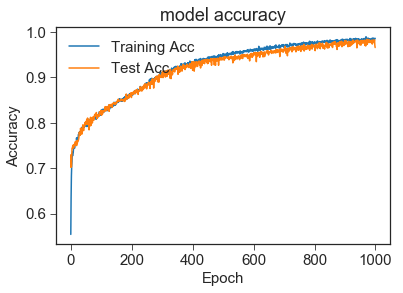

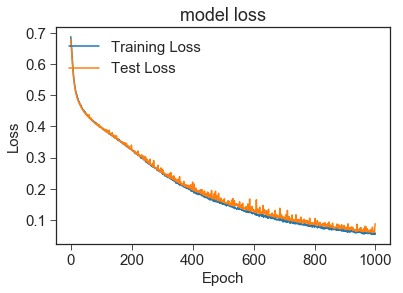

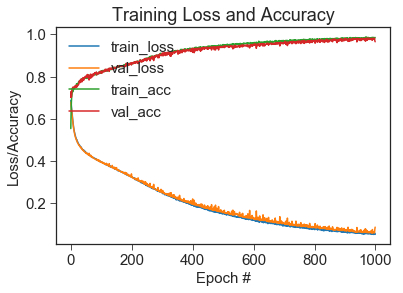

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")